# Introduction

One problem we can have when dealing with categorical target is to have one category that represents over 90%. Maybe you are wondering why is this a problem? Imagine we are using accuracy as a metric, a model that just put every sample in the biggest category will always yield a 90% accuracy even though the model is not learning. 

We will see the importance

In a nutshell, what can we do?
- Check if our data is indeed imbalanced
- Don't use accuracy as the only metric try using F1-score
- Use confusion matrix to check weather the model is even trying to predict the small categories
- Try oversampling or undersampling . 

Some nice reference:

- https://www.kaggle.com/code/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets
- https://www.youtube.com/watch?v=iTxzRVLoTQ0&ab_channel=StatQuestwithJoshStarmer

In [15]:
# import 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# This Libraries were use in the other example because we needed to predict a numerical value
# now we are predicting a category

# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_absolute_error

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# New libraries that we haven't use yet!
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# These functions are going to be use in the next notebook
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
import scikitplot as skplt


# Let us have a clearer code
from utils import cleaning_data

In [2]:
import plotly.io as pio
import plotly.express as px

pio.renderers.default = "svg"

import os

**Quick words the following dataset are data relating to transaction of creditcards. The minory group are fraud transaction and the big group are the "normal transaction".**

In [3]:
# Here is the data: https://www.kaggle.com/code/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets/input

X_full = pd.read_csv('creditcard.csv')

# This is the real test, but we are going to use a test created by us to use easily ROC-AUC

# X_test_full = pd.read_csv('test.csv', index_col='PassengerId')

# Transported is the target, if there is no target eliminate row associated with it
column_to_predict = "Class"
X_full.dropna(axis=0, subset=[column_to_predict], inplace=True)
y = X_full[column_to_predict]
X = X_full.copy()
X.drop([column_to_predict], axis=1, inplace=True)

all_columns = X.columns


In [4]:
X_full.head(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0


In [5]:
def is_imba(y):
    df = pd.DataFrame({'categories':list(y.value_counts().index),
                    'counts':list(y.value_counts().values)})
    percentage_biggest_class = (df['counts'].max()/df['counts'].sum())*100
    
    print(f"the biggest class has a {round(percentage_biggest_class,2)}% of all the samples in this dataset")
    fig = px.pie(df, values='counts', names='categories', title='Categories in the target values')
    fig.show()
    if percentage_biggest_class>90:
        return print("This class is clearly imbalanced")
    else: 
        return print("This class doesn't look like imbalanced, please make sure looking the graph")
    

the biggest class has a 99.83% of all the samples in this dataset


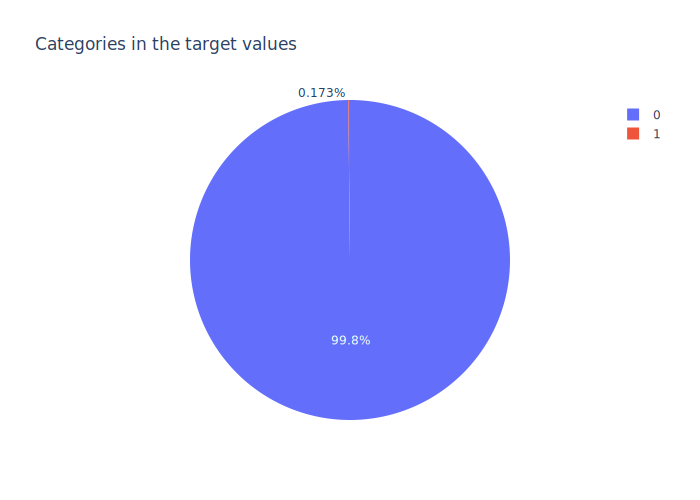

This class is clearly imbalanced


In [6]:
is_imba(y)

# Creating a Naive model (WRONG MODEL) 

Here we will create a wrong model without using any of the techniques for imbalanced dataset to see what we will get.

So this will be the naive approach, 

**please noticed this model is created intensionally not taking into consideration the imbalanced of the dataset to ilustrate the importance of the other methods we are going to use later in the other notebooks!** 


In [7]:
# we do not have null!!
# X.isnull().any()

In [8]:
# All variables are number!! 
# X.dtypes

Notice we could clean a little our code because we do not have categories nor null values, but we are going to continue use our trusty pipeline. 

In [9]:
# notice we use stratify
X, X_test, y, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                random_state=0,stratify=y)  


In [10]:
def fit_model(X,y,X_test=False,
             cv=3,n_jobs=-1,scoring='accuracy',
             max_depth=10,n_estimators=344,n_neighbors=5,thr=0.5,sample_weight=None ):

    # We are gonna use a cross validation now
    
    """
    best model so far is: 
    {'model__max_depth': 10,
    'model__n_estimators': 344,
    'preprocessor__numerical_transformer__imputer__n_neighbors': 5}
    
    
    """

    
    numerical_col = [col for col in X.columns if str(X[col].dtypes)!='object' ]
    numerical_col_imputed = [col for col in numerical_col if X[col].isnull().any()==True]

    categorical_col = [col for col in X.columns if str(X[col].dtypes)=='object' ]
    categorical_col_imputed = [col for col in categorical_col if X[col].isnull().any()==True]
    # n_neighbors = an integer. KNNImputer 
    numerical_transformer = Pipeline(
    steps=[("scaler", StandardScaler()), ("imputer", KNNImputer(n_neighbors=n_neighbors))
          ]
    )

    categorical_transformer =  Pipeline(steps=[
        ('imputer', SimpleImputer(missing_values=pd.NA, strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(transformers=
        [("numerical_transformer", numerical_transformer, numerical_col_imputed),
        ("categorical_transformer", categorical_transformer, categorical_col)],remainder='passthrough')

    # Define model
    model = RandomForestClassifier(max_depth=max_depth,n_estimators=n_estimators ,random_state=0,n_jobs=n_jobs)

    # Bundle preprocessing and modeling code in a pipeline
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ('model', model)
                         ])
   
    # this fit the pipeline to a specific model, giving an specific traning set (notice that the cross-val does not do that)
   
    pipe.fit(X,y,model__sample_weight=sample_weight)
    y_pred = pipe.predict(X_test)
    y_proba = None
    try:
        # X_test = False this will not run and it is ok
        y_proba = pipe.predict_proba(X_test)
    except:
        pass
    
    return y_proba, y_pred

In [11]:
# What we got so far is
y_proba, y_pred = fit_model(X,y,X_test=X_test)

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

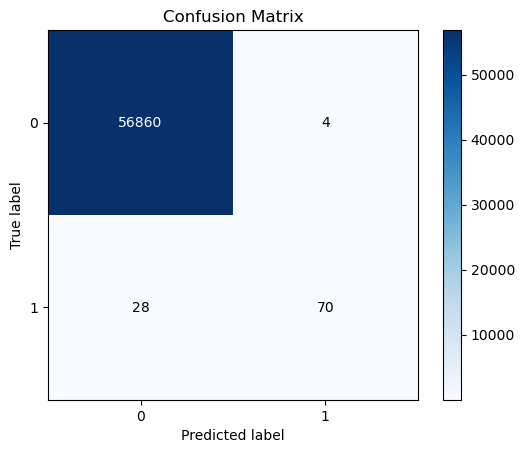

In [12]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred)

In [13]:
def plot_confusion_matrix(y_proba,y_test,thr=0.5):
    y_pred = (y_proba[:, 1] >= thr).astype(int)
    #fpr, tpr, thresholds = roc_curve(y_test,y_pred)
    acurracy = f1_score(y_test, y_pred)
    return print(f"f1 : {round(acurracy,3)*100}% "),skplt.metrics.plot_confusion_matrix(y_test, y_pred)

f1 : 81.39999999999999% 


(None,
 <Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>)

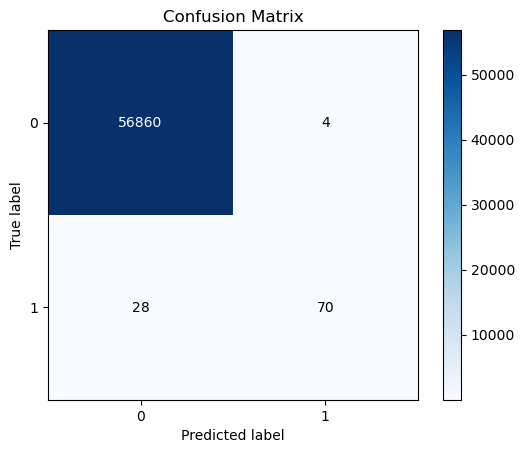

In [16]:
# Over 0.5 we have positive and below negative, a pretty normal way to do it!
# we should get exactly what we get above
plot_confusion_matrix(y_proba,y_test,thr=0.5)

I must admit, we did a better job that I was expencting without changing much of our trusty pipeline. We misclassified 28 element, that is to say, we coudn't identify 28 fraud of 98. But can we do even better? (notice we can also play with the threshold a little, let us play one time to see what we get)

f1 : 83.1% 


(None,
 <Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>)

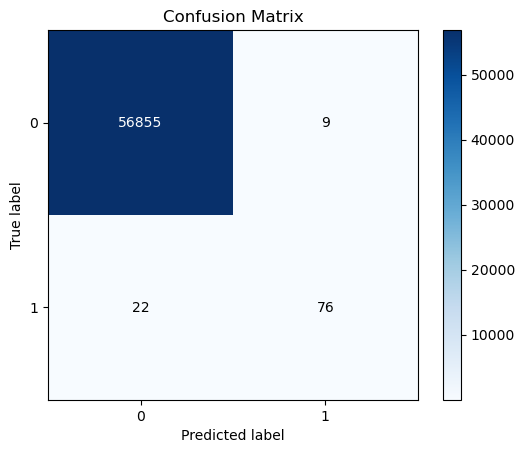

In [17]:
plot_confusion_matrix(y_proba,y_test,thr=0.3)

We could improve a tiny tad the results but can we improve even more using the cool techniques that we describe in the introduction? 

The problem with this model that we are only detecting a little more than a 1/3 of frauds.


## Playing with the scoring a little bit

What would happened if instead of accuracy we choose f1-score
we will use a cv=2 because it is a slow to run

In [18]:
def fix_model_score(X,y,X_test=False,
             cv=2,n_jobs=-1,scoring='accuracy',
             max_depth=10,n_estimators=344,n_neighbors=5,thr=0.5 ):

    # We are gonna use a cross validation now
    
    """
    best model so far is: 
    {'model__max_depth': 10,
    'model__n_estimators': 344,
    'preprocessor__numerical_transformer__imputer__n_neighbors': 5}
    
    
    """

    
    numerical_col = [col for col in X.columns if str(X[col].dtypes)!='object' ]
    numerical_col_imputed = [col for col in numerical_col if X[col].isnull().any()==True]

    categorical_col = [col for col in X.columns if str(X[col].dtypes)=='object' ]
    categorical_col_imputed = [col for col in categorical_col if X[col].isnull().any()==True]
    # n_neighbors = an integer. KNNImputer 
    numerical_transformer = Pipeline(
    steps=[("scaler", StandardScaler()), ("imputer", KNNImputer(n_neighbors=n_neighbors))
          ]
    )

    categorical_transformer =  Pipeline(steps=[
        ('imputer', SimpleImputer(missing_values=pd.NA, strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(transformers=
        [("numerical_transformer", numerical_transformer, numerical_col_imputed),
        ("categorical_transformer", categorical_transformer, categorical_col)],remainder='passthrough')

    # Define model
    model = RandomForestClassifier(max_depth=max_depth,n_estimators=n_estimators ,random_state=0,n_jobs=n_jobs)

    # Bundle preprocessing and modeling code in a pipeline
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ('model', model)
                         ])
    # this "just" give me the score
    distributions = dict(model__n_estimators=randint(low=280,high=380))
    clf = RandomizedSearchCV(pipe, distributions, random_state=0, cv=cv,n_iter=2,scoring=scoring)
    search = clf.fit(X,y)
    
    
    return search

In [19]:
search = fix_model_score(X,y,X_test=X_test,scoring='f1')

In [20]:
y_pred = search.best_estimator_.predict(X_test)

In [21]:
search.best_params_

{'model__n_estimators': 324}

f1: 0.813953488372093


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

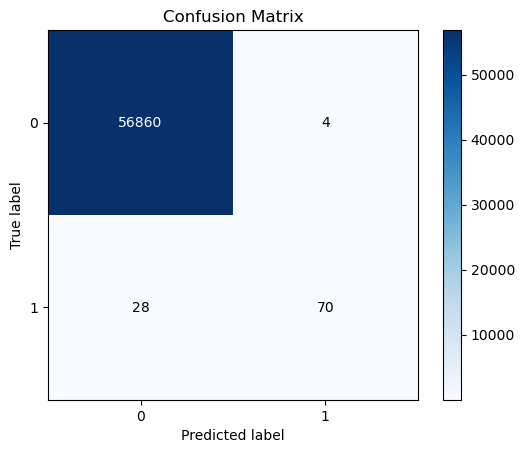

In [22]:
print(f"f1: {f1_score(y_test, y_pred)}")
skplt.metrics.plot_confusion_matrix(y_test, y_pred)

We got exactly the same result, so it looks like we couldn't improve giving a different scoring.
maybe if we have the randomsearch a little longer would change eventually, but this is taking too long!

## Changing weights

In [23]:
def getting_weights(y,smallest_class=1,cost_small_class=50):
    """
    smallest_class is the class with less values that is more expensive to get. 
    """
    sample_weights = [1]*y.shape[0]
    df = pd.DataFrame({"weight":[1]*y.shape[0]},index=y.index)
    # imaging a fraud getting a false negative is 50 times more expensive than a false positive, so this is the idea of the weight in the fraud class
    df.loc[list(y[y==smallest_class].index),'weight']=cost_small_class 
    return df
    

In [24]:
df = getting_weights(y) 

In [25]:
sample_weight = list(df.weight)

In [26]:
y_proba, y_pred = fit_model(X,y,X_test=X_test,sample_weight=sample_weight)

f1: 0.8044692737430168


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

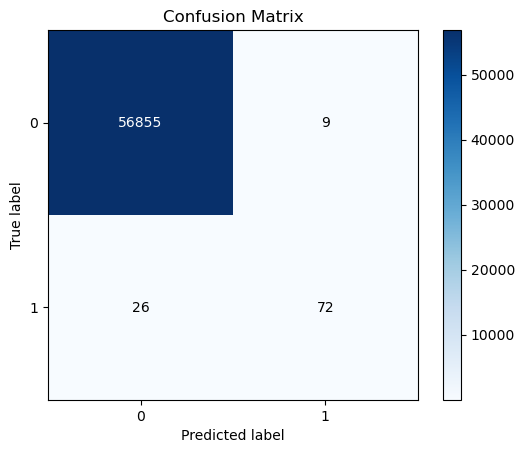

In [27]:
print(f"f1: {f1_score(y_test, y_pred)}")
skplt.metrics.plot_confusion_matrix(y_test, y_pred)

After all the work we put we only were able to correctly get 2 more fraud cases. Notice also we incorrectly assest 5 new normal transaction as a fraud. We can consider this as an improvement. 

Notice that the first model that we run with a threshold of 0.3 gives a better result (**f1 = 83.1%** ), so it looks like adjusting the y_proba gives as better result than adjusting the weights (predicts more fraud and the same amount of incorrectly misclassifier normal transaction as fraud and it is reflected in the f1 = 80.4%) !

f1 : 83.0% 


(None,
 <Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>)

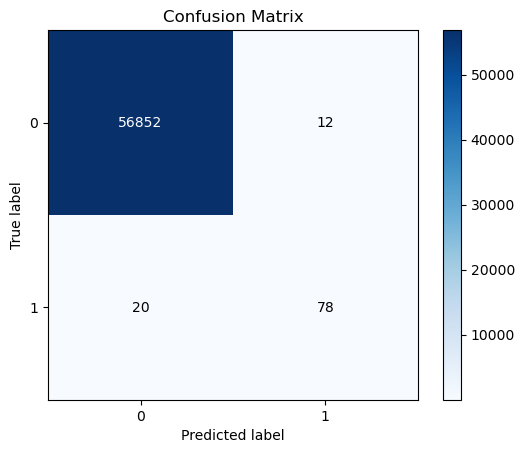

In [28]:
# just one more plot!
plot_confusion_matrix(y_proba,y_test,thr=0.3)

So this is a naive approach to a imbalance dataset. We will try a different approach in the next notebook and we will also try something with the training is taking too long! Stay tuned!